# Housing Prices and Venue Data Analysis in Manhattan

## Table of Contents
* [A. Introduction](#introduction)
* [B. Data Description](#data)
* [C. Methodology and Analysis](#methodology)
* [D. Results](#results)
* [E. Discussion and Conclusion](#conclusion)

## A. Introduction <a name="introduction"></a>
New York City is one of the most expensive cities in the world. It is also the most populous city in USA with an estimated population of 8.6 million distributed over an area of 302 square miles. It consists of five boroughs: Brooklyn, Queens, Manhattan, the Bronx and Staten Island.

If we take a close look at the housing price in New York City, we can see that the difference among boroughs is actually quite large. As shown in the first map below, Manhattan has the highest median housing price, followed by Brooklyn, Queens, Staten Island and the Bronx. The second map shows homeowners' cost-to-income ratio (CTI) in different boroughs. Although Manhattan has the highest housing price, CTI is the lowest in the five boroughs, which shows that homeowners living in Manhattan are within the highest income level.

The high housing price aroused my interest in ananlyzing the neighborhoods in Manhattan with venue data. Is there any pattern in the distribution of venues among neighborhoods of similar housing price? The exploration of this problem can also be used by people when deciding housing location. This decision partically reflects the tradeoff between lower price and more convenient neighborhood. 

In the following part, I will first decribe the data and their source. Then I will discuss in detail about the methodology and conduct data analysis. In the results and discussion part, I will put forward conclusions and possible directions to further research on this topic. 

The research report is presented as the format of Jupyter Notebook. 

In [575]:
import folium
import pandas as pd

In [576]:
#import data for NYC median housing price by borough
df=pd.read_excel('test_data.xlsx',sheet_name='borough_price')

In [577]:
#show difference in housing price
world_geo = r'nyc.geojson'
latitude = 40.737746
longitude = -73.989496
world_map = folium.Map(location=[latitude, longitude], zoom_start=10)
world_map.choropleth(
    geo_data=world_geo,
    data=df,
    columns=['borough', 'median'],
    key_on='feature.properties.borough',
    #threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Median Housing Price in NYC',
    reset=True
)
world_map

In [578]:
#show difference in cost-to-income ratio
world_map = folium.Map(location=[latitude, longitude], zoom_start=10)
world_map.choropleth(
    geo_data=world_geo,
    data=df,
    columns=['borough', 'homeowners_CTI'],
    key_on='feature.properties.borough',
    #threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Median Housing Price in NYC',
    reset=True
)
world_map

## B. Data Description <a name="data"></a>
In this research, I mainly use these data:
1. I use NYC and Manhattan geojson file to plot neighborhood boundaries in the map. These data come from website http://data.beta.nyc/. This website also provides many other interesting data which can be used for deeper research.
2. I get median housing prices for boroughs, neighborhood info, average housing prices for different neighborhoods in Manhattan from Zillow website. Since Zillow doesn't have the complete info for each Manhattan neighborhood, the following analysis is based on selected neighborhoods.
3. I use Foursquare API to get venue info for each neighborhood in Manhattan.
4. I use Geocoder Python package to get coordinate info for each neighborhood.

In [579]:
#import average housing price in Manhattan by neighborhood
nb_price=pd.read_excel('test_data.xlsx',sheet_name='zillow_price_index')
nb_price=nb_price.dropna().reset_index(drop=True)
print (nb_price.shape)
nb_price.head()

(18, 3)


,neighborhood,Zillow Home Value Index,zip_code
0,Carnegie Hill,1726100.0,10128
1,Central Park,924800.0,10024
2,East Harlem,815500.0,10035
3,East Village,1325900.0,10009
4,Financial District,1018500.0,"10038,10004,10007"


Since each neighborhood may consist of multiple zip code info, I do the data cleaning work below in order to put each zip code in one row.

In [580]:
nb_price['zip_code']=nb_price['zip_code'].astype(str)
tmp=nb_price.zip_code.str.split(',', expand=True)
nb_price_tmp = pd.concat([nb_price[['neighborhood','Zillow Home Value Index']],tmp],axis=1)
nb_price_zip =pd.DataFrame()
for i in range(len(nb_price_tmp)):
    for j in range(tmp.shape[1]):
        nb_price_zip=nb_price_zip.append(pd.Series([nb_price_tmp.iloc[i,0],nb_price_tmp.iloc[i,1],nb_price_tmp.iloc[i,2+j]]),ignore_index=True)
nb_price_zip=nb_price_zip.dropna().reset_index(drop=True)
nb_price_zip.columns = ['neighborhood','Zillow Home Value Index','zip_code']
nb_price_zip.head()                   

,neighborhood,Zillow Home Value Index,zip_code
0,Carnegie Hill,1726100.0,10128
1,Central Park,924800.0,10024
2,East Harlem,815500.0,10035
3,East Village,1325900.0,10009
4,Financial District,1018500.0,10038


In [201]:
#!conda install -c conda-forge geocoder --yes 
#!conda install -c conda-forge geopy --yes 

With neighborhood name info, I can use Python **Geocoder** package to get coordinate (latitude&longitude) info for each neoghborhood.

In [582]:
from geopy.geocoders import Nominatim
coordinate =pd.DataFrame()
for i in range(len(nb_price_zip)):
    address = nb_price_zip.iloc[i,0]+',New York,NY'
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    coordinate=coordinate.append(pd.Series([nb_price_zip.iloc[i,0],latitude,longitude]),ignore_index=True )

In [583]:
#combine coordinate info with original dataframe
nb_price_cord=pd.concat([nb_price_zip,coordinate.iloc[:,1:]],axis=1)
nb_price_cord=nb_price_cord.rename(index=str,columns={1:'latitude',2:'longitude'})
nb_price_cord.head()

,neighborhood,Zillow Home Value Index,zip_code,latitude,longitude
0,Carnegie Hill,1726100.0,10128,40.784197,-73.954339
1,Central Park,924800.0,10024,40.783848,-73.964573
2,East Harlem,815500.0,10035,40.794722,-73.942500
3,East Village,1325900.0,10009,40.729269,-73.987361
4,Financial District,1018500.0,10038,40.707612,-74.009378


**Visualize** housing prices in different neighborhoods

In [584]:
#show housing price difference for different neighborhoods in manhattan
world_geo = r'manhattan.geojson'
latitude = 40.737746
longitude = -73.989496
world_map = folium.Map(location=[latitude, longitude], zoom_start=12)
world_map.choropleth(
    geo_data=world_geo,
    data=nb_price_cord,
    columns=['zip_code', 'Zillow Home Value Index'],
    key_on='feature.properties.postalCode',
    #threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Selected Neighborhood Housing Price in Manhattan',
    reset=True
)
world_map

## C. Methodology and Analysis <a name="methodology"></a>
I use **Folium** package to visualize all the maps above. What's more, with the coordinate info, I can further use **Foursquare API** to explore venues around this area.

In this research, I set radius parameter to be 500. It means that in search of each neighborhood, it will return results within 500 meters radius for given coordinate.

In [586]:
#set parameters for Foursquare inquiry
import requests # library to handle requests
CLIENT_ID = '15VFWJCTZE4GGMH354ZIZBZJQ5RW1LMSCYFWQY4UVWQERT54' # your Foursquare ID
CLIENT_SECRET = 'WMPYUZYKZ1XRDQEKBNC5U302NMJXKRE4QACXFOFU5JLWBXDR' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100

In [587]:
#define venue function
def getNearbyVenues(names, latitudes, longitudes, radius=500):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)           
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']   
    return(nearby_venues)

In [297]:
manhattan_venues = getNearbyVenues(names=nb_price_cord['neighborhood'],latitudes=nb_price_cord['latitude'],longitudes=nb_price_cord['longitude'])

Carnegie Hill
Central Park
East Harlem
East Village
Financial District
Financial District
Financial District
Flatiron District
Greenwich Village
Little Italy
Lower East Side
Morningside Heights
Murray Hill
Roosevelt Island
SoHo
SoHo
Sutton Place
Tribeca
Upper East Side
Upper East Side
Upper East Side
Washington Heights
Washington Heights
Washington Heights
West Village


In [588]:
print(manhattan_venues.shape)
manhattan_venues.head()

(1970, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Carnegie Hill,40.784197,-73.954339,Kitchen Arts & Letters,40.784226,-73.952135,Bookstore
1,Carnegie Hill,40.784197,-73.954339,92nd Street Y,40.783077,-73.952772,Community Center
2,Carnegie Hill,40.784197,-73.954339,92nd Street Y May Center,40.783108,-73.952758,Gym / Fitness Center
3,Carnegie Hill,40.784197,-73.954339,Marinara Pizza Upper East,40.782538,-73.953359,Pizza Place
4,Carnegie Hill,40.784197,-73.954339,Sfoglia,40.783419,-73.952768,Italian Restaurant


The table below shows the returned venue numbers in each neighborhood. Upper East Side, Financial District and SoHo are among the top three based on venue numbers while Central Park, Roosevelt Island and Sutton Place are among the lowest three. The number somewhat shows positive correlation with housing price: the higher the housing price, the more venues around this area. This result makes sense since higher housing price usually means higher demand, which also leads to the development of business district.

However since the inquiry doesn't run all the possible results, it only partially tells the story. The search result heavily relies on the provided coordinates. 

In [589]:
#total venues for each neighborhood
venue=pd.DataFrame(manhattan_venues.groupby('Neighborhood').count()['Venue'].sort_values(ascending=False))
venue_number=venue.merge(nb_price,left_on='Neighborhood',right_on='neighborhood',how='left')
venue_number.set_index('neighborhood')

,Venue,Zillow Home Value Index,zip_code
neighborhood,,,
Upper East Side,300,1286000.0,"10021,10065,10128"
Financial District,300,1018500.0,"10038,10004,10007"
SoHo,200,2870000.0,"10012,10013"
Washington Heights,135,658500.0,"10033,10032,10040"
West Village,100,1932500.0,10014
East Village,100,1325900.0,10009
Flatiron District,100,1890500.0,10010
Greenwich Village,100,1471900.0,12834
Little Italy,100,2015000.0,10013


Since there are too many different categories of venues, it makes the analysis hard. To cope with this problem, I use **one hot encoding** method to transform categorical variables into binary varibles.

In [590]:
#one hot encoding for venue
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Accessories Store,American Restaurant,Animal Shelter,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Vietnamese Restaurant,Watch Shop,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Carnegie Hill,0.00,0.027778,0.0,0.0,0.00,0.0,0.027778,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.013889,0.041667,0.0,0.00,0.013889
1,Central Park,0.00,0.000000,0.0,0.0,0.00,0.0,0.071429,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.000000
2,East Harlem,0.00,0.000000,0.0,0.0,0.00,0.0,0.000000,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.023810,0.000000,0.0,0.00,0.000000
3,East Village,0.00,0.010000,0.0,0.0,0.01,0.0,0.000000,0.01,0.01,...,0.01,0.0,0.0,0.0,0.0,0.010000,0.000000,0.0,0.00,0.010000
4,Financial District,0.01,0.020000,0.0,0.0,0.00,0.0,0.000000,0.00,0.01,...,0.00,0.0,0.0,0.0,0.0,0.000000,0.030000,0.0,0.01,0.010000


To find out the pattern among neighborhoods of similar housing prices, I use the function below to select top 10 common venue categories for each neighborhood.

In [591]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)   
    return row_categories_sorted.index.values[0:num_top_venues]

#create dataframe that shows the top 10 venues for all neighborhoods
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in range(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']
for ind in range(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Carnegie Hill,Café,Pizza Place,Spa,Wine Shop,Italian Restaurant,Gym,Art Museum,Bookstore,Bar,Playground
1,Central Park,Exhibit,Park,Art Museum,Theater,Garden,Baseball Field,Track,Music Venue,Playground,Monument / Landmark
2,East Harlem,Bakery,Pizza Place,Mexican Restaurant,Latin American Restaurant,Taco Place,Deli / Bodega,Spanish Restaurant,Shipping Store,Steakhouse,Street Art
3,East Village,Japanese Restaurant,Chinese Restaurant,Ice Cream Shop,Coffee Shop,Seafood Restaurant,Sushi Restaurant,Dessert Shop,Café,Ramen Restaurant,Soba Restaurant
4,Financial District,Coffee Shop,Sandwich Place,Steakhouse,Hotel,Juice Bar,Italian Restaurant,Gym,Café,Food Truck,Spa


In [592]:
#combine venue info with housing price info
data_combined = neighborhoods_venues_sorted.merge(nb_price,left_on='Neighborhood',right_on='neighborhood',how='left').reset_index(drop=True)
manhattan_grouped_sum = manhattan_onehot.groupby('Neighborhood').sum().reset_index()
data_combined = data_combined.merge(manhattan_grouped_sum,on='Neighborhood',how='left').reset_index(drop=True)
data_combined=data_combined.drop(['neighborhood','zip_code'],axis=1)
data_combined.columns.tolist()
column_name=['Neighborhood']+['Zillow Home Value Index']+data_combined.columns[1:11].tolist()+data_combined.columns[12:].tolist()
data_combined = data_combined[column_name]
data_combined=data_combined.sort_values(by=['Zillow Home Value Index']).reset_index(drop=True)

To make the result more straightforward, I use horizontal bar chart to visualize the venue category distribution for top 5 highest and 5 lowest housing price neighborhoods. 

Those for 5 lowest housing price neighborhoods are pizza place, Latin American, Bakery, Mexican Restaurant and Italian Restaurant. Those for 5 highest housing price neighborhoods are Italian Restaurant, Clothing Store, Boutique, Ametican Restaurant and Bakery. We can see that the top 5 venues for 5 lowest housing price neighborhoods are mainly food stores. At the same time, There are more shopping places included in the 5 highest housing price neighborhoods. 

The relationship between housing price and district development is **mutual**. When the area becomes a more complete business district, it will attract more people, which leads to higher demand and thus higher prices. When the area becomes more expensive and highly demanded, it will also attract more people to start new business.

Text(0.5, 1.0, 'Top 5 venues within 5 highest housing price neighborhoods')

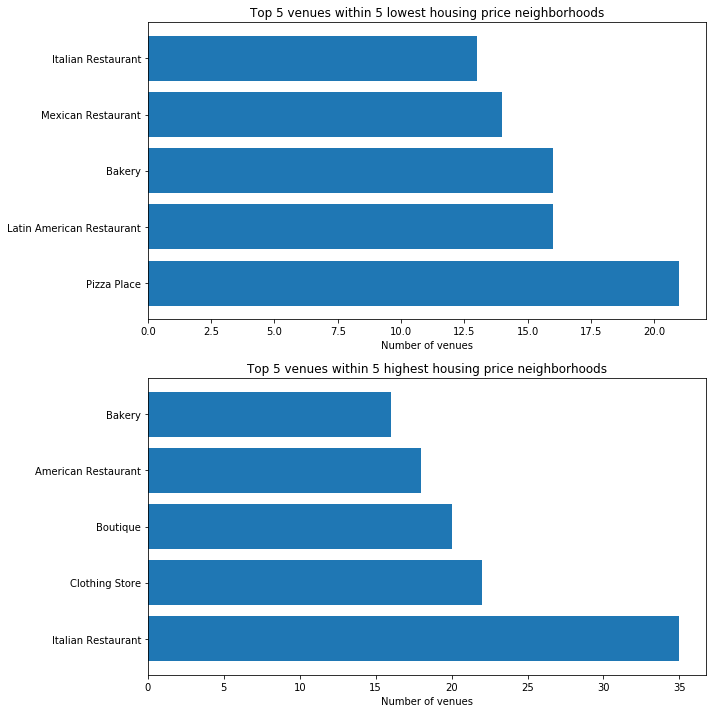

In [593]:
import matplotlib.pyplot as plt 
%matplotlib inline
top_borough=5
top_categories=5
#top 5 lowest price neighborhoods
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
low_price = data_combined[:top_low_borough].sum(axis=0)[12:]
low_price=low_price.sort_values(ascending=False)[:top_categories]
y_pos=range(len(low_price))
plt.barh(y_pos, low_price.tolist())
plt.yticks(y_pos, low_price.index)
plt.xlabel('Number of venues')
plt.title('Top 5 venues within 5 lowest housing price neighborhoods')
#top 5 highest price neighborhoods
plt.subplot(2,1,2)
high_price = data_combined[-top_low_borough:].sum(axis=0)[12:]
high_price=high_price.sort_values(ascending=False)[:top_categories]
y_pos=range(len(high_price))
plt.barh(y_pos, high_price.tolist())
plt.yticks(y_pos, high_price.index)
plt.xlabel('Number of venues')
plt.title('Top 5 venues within 5 highest housing price neighborhoods')

Since there are common venue categories among different neighborhoods, I further use **kmean** method to cluster neighborhoods into different groups.

In [594]:
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
#preprocess and normalize data
dataset_array=manhattan_grouped_sum.iloc[:,1:].values
#print(dataset_array.dtype)  #make sure data type are the same
#print(dataset_array)
cluster_dataset = StandardScaler().fit_transform(dataset_array)
#build kmean object
k_means = KMeans(init="k-means++", n_clusters=5, n_init=12)  #use 5 as an example
k_means.fit(cluster_dataset)
k_means_labels = k_means.labels_
k_means_labels

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([2, 2, 2, 1, 4, 2, 2, 0, 1, 2, 2, 2, 3, 2, 2, 3, 2, 2], dtype=int32)

When using unsupervised kmean method, the hyperparameter k is very important in deciding the grouping result. I use elbow method to choose k. From the graph below, we can see that **4** is optimal since it shows a significant decrease of distortion at that point and the graph becomes smooth afterwards.

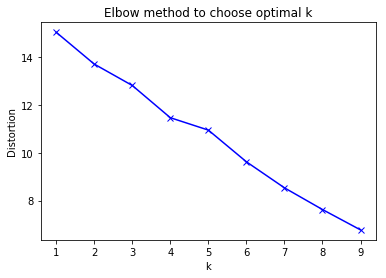

The optimal k is 4


In [612]:
from scipy.spatial.distance import cdist
distortions = []
K=range(1,10)
for k in K:
    k_means = KMeans(n_clusters=k)
    k_means.fit(cluster_dataset)
    distortions.append(sum(np.min(cdist(cluster_dataset, k_means.cluster_centers_, 'euclidean'), axis=1)) / cluster_dataset.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow method to choose optimal k')
plt.show()
print ('The optimal k is 4')


In [613]:
#use k=4 to fit kmean model
k=4
k_means = KMeans(init="k-means++", n_clusters=k, n_init=12,random_state=1)
k_means.fit(cluster_dataset)
k_means_labels = k_means.labels_
clustered_nb = pd.concat([manhattan_grouped_sum,pd.DataFrame(k_means_labels)],axis=1).rename(columns={0:'Group'}).loc[:,['Neighborhood','Group']]

#merge coordinate info to clustered_nb
cluster_map=nb_price_cord.merge(clustered_nb,left_on='neighborhood',right_on='Neighborhood',how='left')
cluster_map=cluster_map.loc[:,['neighborhood','Group','latitude','longitude']]
cluster_map.head()

,neighborhood,Group,latitude,longitude
0,Carnegie Hill,0,40.784197,-73.954339
1,Central Park,0,40.783848,-73.964573
2,East Harlem,0,40.794722,-73.942500
3,East Village,0,40.729269,-73.987361
4,Financial District,3,40.707612,-74.009378


With the clustering result, I use folium package to visualize grouping in the map.

In [614]:
import matplotlib
#create map
latitude = 40.776895
longitude = -73.968694  #get manhattan midtown coordinate from google map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)
# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = plt.cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [matplotlib.colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster_map['latitude'], cluster_map['longitude'], cluster_map['neighborhood'], cluster_map['Group']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

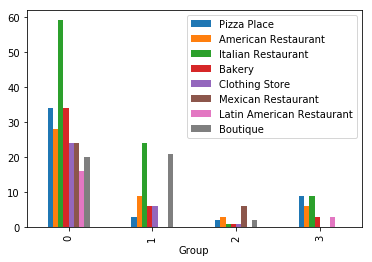

In [615]:
cluster_df = clustered_nb.merge(manhattan_grouped_sum,on='Neighborhood',how='left')
cluster_group = cluster_df.groupby('Group').sum()
categories = list(set(low_price.index.tolist()+high_price.index.tolist()))
cluster_group=cluster_group[categories]
cluster_group.plot.bar()

The bar chart above helps to identify the characteristic of each group. We can label each cluster as below:
1. "Italian Restaurant"
2. "Boutique"
3. "Mexican Restaurant"
4. "Pizza Place"

## D. Results <a name="results"></a>
In this report, I combine machine learning method, data analysis and visualization to research on the similarity/difference among Manhattan neighborhoods based on venue data. This result does show that distribution of venue categories is different between relative cheap area and expensive area. Housing price is decided by multiple factors. **Neighborhood convenience** is definitely one of them. This research result can be used by people when deciding new house locations, which is a tradeoff between housing price and convenience.

## E. Discussion and Conclusion <a name="conclusion"></a>
The decisive factors of housing prices are complex. In this research, I focus on one of the pointcuts - **venue info** to analyze its influence. However, different house buyers have different requirements in housing location. For example, the elders want to live closer to hospitals; parents with young kids want to live closer to schools. These analysis can be carries out by combining hospital/school geojson files.

Housing price is always an important topic. We can make wiser decision when we take both personal requirement and neighborhood info into consideration. This research is only a begining. There are more factors to be considered and studied in the future. 